# Import libraries

In [1]:
import os
import functools
import gzip
import math
import json
import anndata
import scipy.io
import scipy.sparse
import pandas as pd
import scanpy as sc
import numpy as np
import scrublet
import sklearn.cluster
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *

# Config

In [2]:
theme_set(theme_classic() + theme(panel_grid_major=element_line()))

In [3]:
rules = {
    "frac_mito": (0, 0.1),
    "counts": (1000, 20000),
    "genes": (70, 6000),
}

In [4]:
celltype_map = {
    "neuron": ["Rbfox3", "Calb2", "Nefl", "Th"],
    "lineage": ["Aqp4", "Egfr", "Mki67", "Dcx"],
    "microglia": ["Itgam", "Ptprc"],
    "oligo": ["Cldn11"],
    "oec": ["Apod"],
    "pericyte": ["Foxd1", "Colec12"],
    "opc": ["Olig1", "Olig2", "Lhfpl3", "Cntn1"],
    "endothelial": ["Prom1", "Cldn5", "Pecam1"],
    "ependymal": ["Cald1", "Sod3"],
}

In [5]:
hto_order = ["SVZ1", "SVZ2", "ROB1", "ROB2", "Unclear"]

# Load data

In [6]:
d = sc.read("data/ifnagrko_raw.h5ad")
d.var_names_make_unique()
d

AnnData object with n_obs × n_vars = 844265 × 32287
    obs: 'batch', 'yfp_count', 'kanr_count', 'SVZ1', 'SVZ2', 'ROB1', 'ROB2', 'unmapped'
    var: 'gene_id'
    obsm: 'hto'
    layers: 'spliced', 'unspliced'

# Preprocessing

## Filter

In [7]:
sc.pp.filter_cells(d, min_counts=100)
sc.pp.filter_genes(d, min_cells=3)
d

AnnData object with n_obs × n_vars = 99768 × 20830
    obs: 'batch', 'yfp_count', 'kanr_count', 'SVZ1', 'SVZ2', 'ROB1', 'ROB2', 'unmapped', 'n_counts'
    var: 'gene_id', 'n_cells'
    obsm: 'hto'
    layers: 'spliced', 'unspliced'

In [8]:
d.var["mt"] = d.var_names.str.startswith("mt-")
d.obs["counts"] = d.X.sum(axis=1).A1
d.obs["genes"] = (d.X > 0).sum(axis=1).A1
d.obs["counts_mito"] = d[:,d.var.mt].X.sum(axis=1).A1
d.obs["frac_mito"] = d.obs["counts_mito"] / d.obs["counts"]
d

AnnData object with n_obs × n_vars = 99768 × 20830
    obs: 'batch', 'yfp_count', 'kanr_count', 'SVZ1', 'SVZ2', 'ROB1', 'ROB2', 'unmapped', 'n_counts', 'counts', 'genes', 'counts_mito', 'frac_mito'
    var: 'gene_id', 'n_cells', 'mt'
    obsm: 'hto'
    layers: 'spliced', 'unspliced'

In [9]:
scrub = scrublet.Scrublet(d.X)
d.obs["scrub_score"], d.obs["scrub_label"] = scrub.scrub_doublets()
d

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.40
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 0.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 18.6%
Elapsed time: 309.1 seconds


AnnData object with n_obs × n_vars = 99768 × 20830
    obs: 'batch', 'yfp_count', 'kanr_count', 'SVZ1', 'SVZ2', 'ROB1', 'ROB2', 'unmapped', 'n_counts', 'counts', 'genes', 'counts_mito', 'frac_mito', 'scrub_score', 'scrub_label'
    var: 'gene_id', 'n_cells', 'mt'
    obsm: 'hto'
    layers: 'spliced', 'unspliced'

In [10]:
exclusions = {key: ~d.obs[key].between(*rules[key], inclusive=True) for key in ["frac_mito", "counts", "genes"]}
exclusions["scrublet"] = d.obs.scrub_label
d.obs["exclude"] = functools.reduce(lambda a, b: a | b, exclusions.values())

In [11]:
d.obs.exclude.value_counts()

True     81466
False    18302
Name: exclude, dtype: int64

In [12]:
d = d[~d.obs.exclude,:]

In [13]:
d

View of AnnData object with n_obs × n_vars = 18302 × 20830
    obs: 'batch', 'yfp_count', 'kanr_count', 'SVZ1', 'SVZ2', 'ROB1', 'ROB2', 'unmapped', 'n_counts', 'counts', 'genes', 'counts_mito', 'frac_mito', 'scrub_score', 'scrub_label', 'exclude'
    var: 'gene_id', 'n_cells', 'mt'
    obsm: 'hto'
    layers: 'spliced', 'unspliced'

## Normalisation

In [14]:
d.layers["raw_counts"] = d.X.copy()

In [15]:
sc.pp.normalize_total(d, target_sum=1e4)
sc.pp.log1p(d)
d.layers["lognormal"] = d.X.copy()
d

AnnData object with n_obs × n_vars = 18302 × 20830
    obs: 'batch', 'yfp_count', 'kanr_count', 'SVZ1', 'SVZ2', 'ROB1', 'ROB2', 'unmapped', 'n_counts', 'counts', 'genes', 'counts_mito', 'frac_mito', 'scrub_score', 'scrub_label', 'exclude'
    var: 'gene_id', 'n_cells', 'mt'
    uns: 'log1p'
    obsm: 'hto'
    layers: 'spliced', 'unspliced', 'raw_counts', 'lognormal'

# Sample names

In [16]:
d.obs["genotype"] = [x.split("-")[1].split("_")[0] for x in d.obs.index]
d.obs["age"] = ["old" if "20mo" in x else "young" for x in d.obs.index]

In [17]:
d.obs.age

barcode
AAACCCAGTCTCCTGT-WT_20mo_2021_001      old
AAACGAAAGGTACTGG-WT_20mo_2021_001      old
AAACGAACATGGCTGC-WT_20mo_2021_001      old
AAACGAAGTAGCTGAG-WT_20mo_2021_001      old
AAACGAATCACCCTCA-WT_20mo_2021_001      old
                                     ...  
TTTGGTTCATGACTTG-WT_4mo_2021_001     young
TTTGGTTGTTCCTTGC-WT_4mo_2021_001     young
TTTGTTGAGCCGTTAT-WT_4mo_2021_001     young
TTTGTTGCAGATGCGA-WT_4mo_2021_001     young
TTTGTTGTCTGAGCAT-WT_4mo_2021_001     young
Name: age, Length: 18302, dtype: object

In [18]:
{x.split("-")[1].split("_")[1] for x in d.obs.index}

{'20mo', '4mo'}

In [19]:
d.obs.genotype

barcode
AAACCCAGTCTCCTGT-WT_20mo_2021_001    WT
AAACGAAAGGTACTGG-WT_20mo_2021_001    WT
AAACGAACATGGCTGC-WT_20mo_2021_001    WT
AAACGAAGTAGCTGAG-WT_20mo_2021_001    WT
AAACGAATCACCCTCA-WT_20mo_2021_001    WT
                                     ..
TTTGGTTCATGACTTG-WT_4mo_2021_001     WT
TTTGGTTGTTCCTTGC-WT_4mo_2021_001     WT
TTTGTTGAGCCGTTAT-WT_4mo_2021_001     WT
TTTGTTGCAGATGCGA-WT_4mo_2021_001     WT
TTTGTTGTCTGAGCAT-WT_4mo_2021_001     WT
Name: genotype, Length: 18302, dtype: object

# Dimensionality reductions

In [20]:
sc.pp.scale(d, zero_center=False)
sc.tl.pca(d, n_comps=50)
sc.pp.neighbors(d, n_neighbors=15)
sc.tl.umap(d)
d

AnnData object with n_obs × n_vars = 18302 × 20830
    obs: 'batch', 'yfp_count', 'kanr_count', 'SVZ1', 'SVZ2', 'ROB1', 'ROB2', 'unmapped', 'n_counts', 'counts', 'genes', 'counts_mito', 'frac_mito', 'scrub_score', 'scrub_label', 'exclude', 'genotype', 'age'
    var: 'gene_id', 'n_cells', 'mt', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'hto', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'raw_counts', 'lognormal'
    obsp: 'distances', 'connectivities'

... storing 'genotype' as categorical
... storing 'age' as categorical


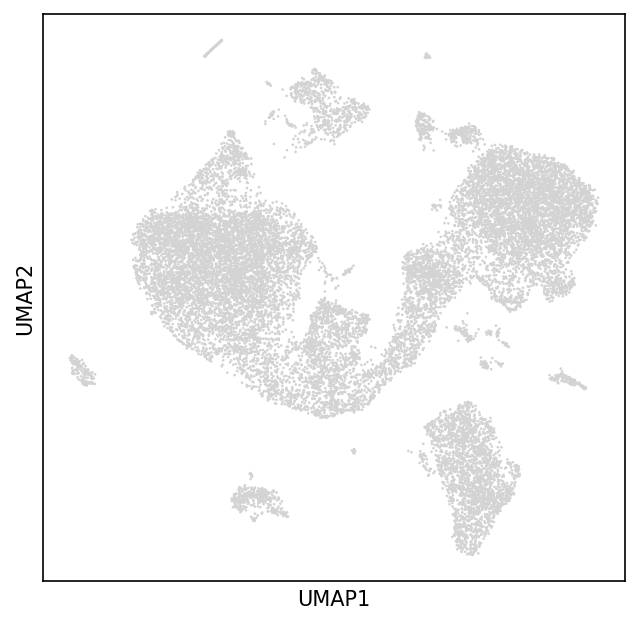

In [21]:
plt.rcParams['figure.figsize'] = [5, 5]
plt.rcParams['figure.dpi'] = 150
sc.pl.umap(d)

# Cluster

In [22]:
sc.tl.leiden(d)
d.obs["dbscan"] = sklearn.cluster.DBSCAN().fit_predict(d.obsm["X_umap"]).astype(str)
dbscan_value_counts = d.obs.dbscan.value_counts()
lineage_cluster_id = dbscan_value_counts.index[dbscan_value_counts.argmax()]
d.obs["is_lineage"] = (d.obs.dbscan == lineage_cluster_id)
d

AnnData object with n_obs × n_vars = 18302 × 20830
    obs: 'batch', 'yfp_count', 'kanr_count', 'SVZ1', 'SVZ2', 'ROB1', 'ROB2', 'unmapped', 'n_counts', 'counts', 'genes', 'counts_mito', 'frac_mito', 'scrub_score', 'scrub_label', 'exclude', 'genotype', 'age', 'leiden', 'dbscan', 'is_lineage'
    var: 'gene_id', 'n_cells', 'mt', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'hto', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'raw_counts', 'lognormal'
    obsp: 'distances', 'connectivities'

... storing 'dbscan' as categorical


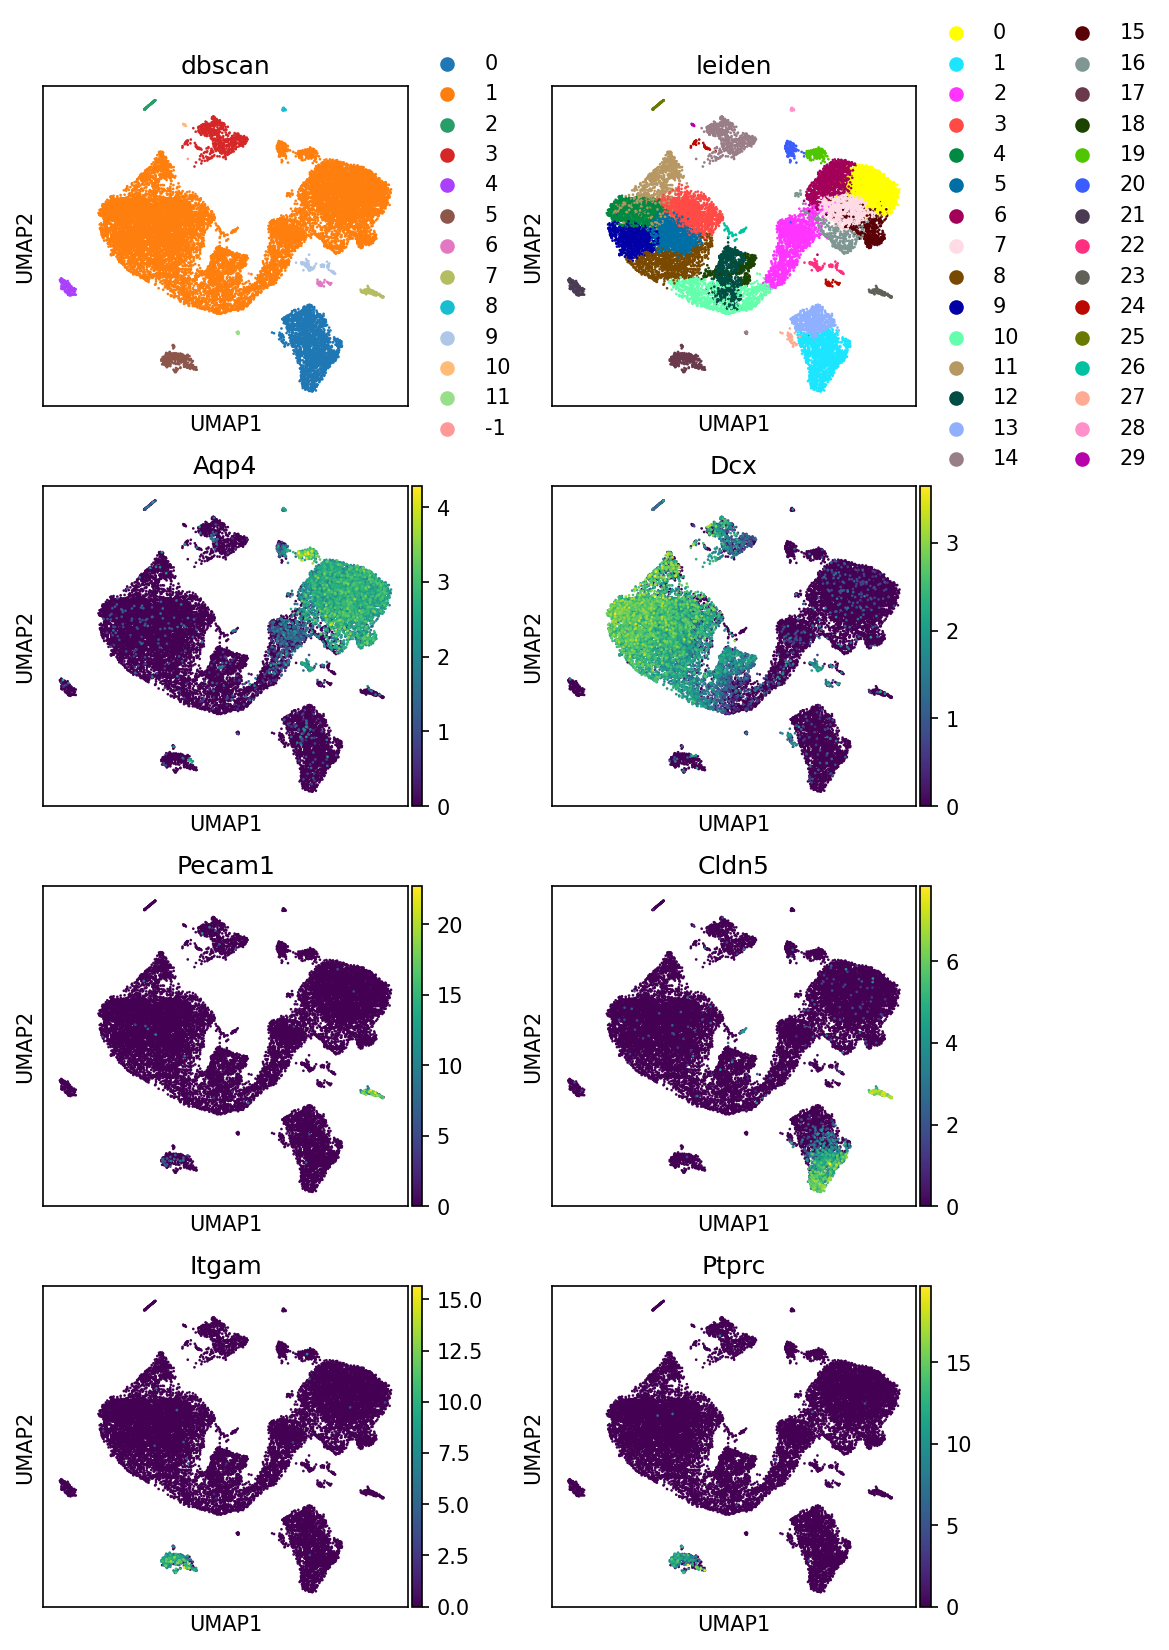

In [23]:
plt.rcParams['figure.figsize'] = [3, 3]
plt.rcParams['figure.dpi'] = 150
sc.pl.umap(d, color=["dbscan", "leiden", "Aqp4", "Dcx", "Pecam1", "Cldn5", "Itgam", "Ptprc"], ncols=2)

# HTO zone assignment

In [24]:
rob_htos = [h.startswith("ROB") for h in hto_order]
svz_htos = [h.startswith("SVZ") for h in hto_order]
d.obs["rob_sum"] = d.obsm["hto"][:,rob_htos].sum(axis=1)
d.obs["svz_sum"] = d.obsm["hto"][:,svz_htos].sum(axis=1)
d.obs["hto_sum"] = d.obs.rob_sum + d.obs.svz_sum
d.obs["svz_frac"] = d.obs.svz_sum / d.obs.hto_sum
d

AnnData object with n_obs × n_vars = 18302 × 20830
    obs: 'batch', 'yfp_count', 'kanr_count', 'SVZ1', 'SVZ2', 'ROB1', 'ROB2', 'unmapped', 'n_counts', 'counts', 'genes', 'counts_mito', 'frac_mito', 'scrub_score', 'scrub_label', 'exclude', 'genotype', 'age', 'leiden', 'dbscan', 'is_lineage', 'rob_sum', 'svz_sum', 'hto_sum', 'svz_frac'
    var: 'gene_id', 'n_cells', 'mt', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'dbscan_colors', 'leiden_colors'
    obsm: 'hto', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'raw_counts', 'lognormal'
    obsp: 'distances', 'connectivities'

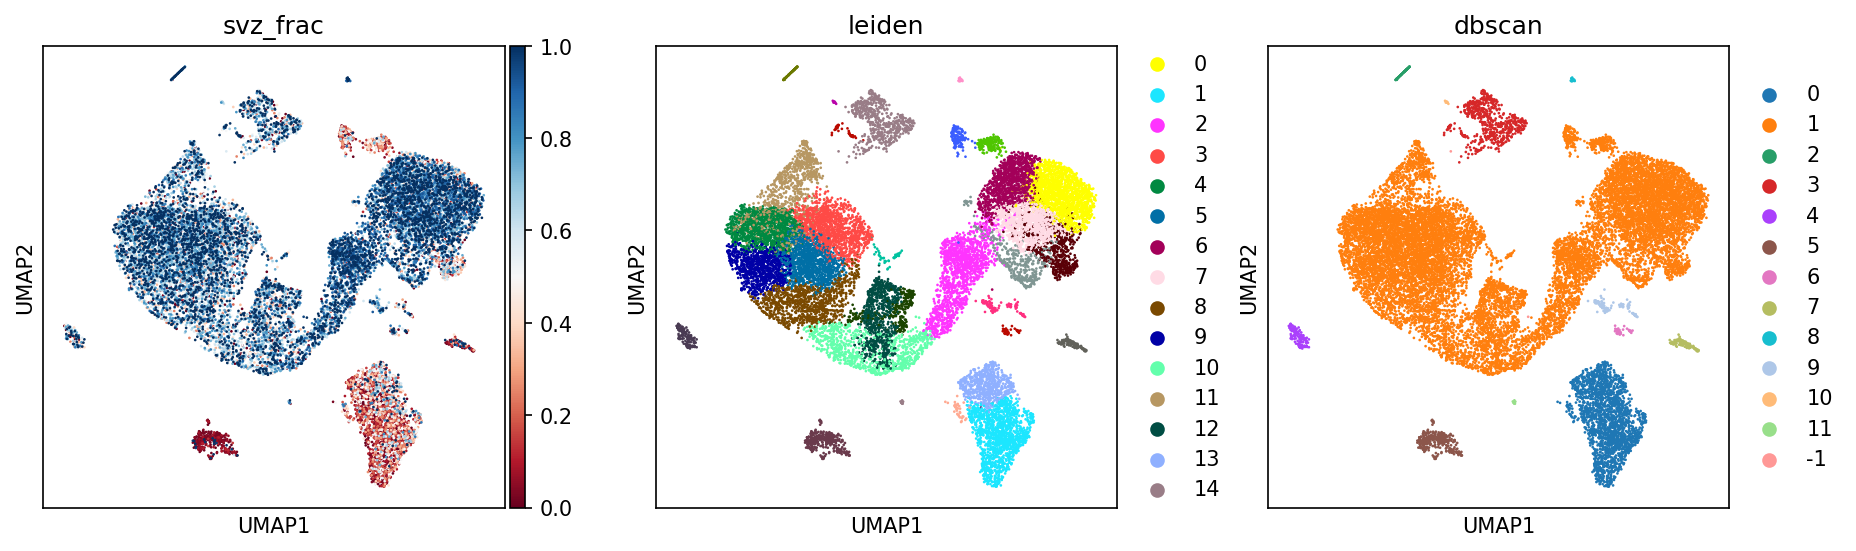

In [25]:
plt.rcParams['figure.figsize'] = [4, 4]
plt.rcParams['figure.dpi'] = 150
sc.pl.umap(d, color=["svz_frac", "leiden", "dbscan"], color_map=matplotlib.cm.RdBu)

# Celltypes

In [26]:
marker_map_tups = functools.reduce(lambda x, y: x+y, [[(key, value) for value in markers] for (key, markers) in celltype_map.items()])
marker_genes = [tup[1] for tup in marker_map_tups]
expr = pd.DataFrame(d[:,marker_genes].X.todense(), index=d.obs.index, columns=pd.MultiIndex.from_tuples(marker_map_tups))
expr = expr.groupby(level=0, axis=1).sum()

<AxesSubplot:ylabel='dbscan'>

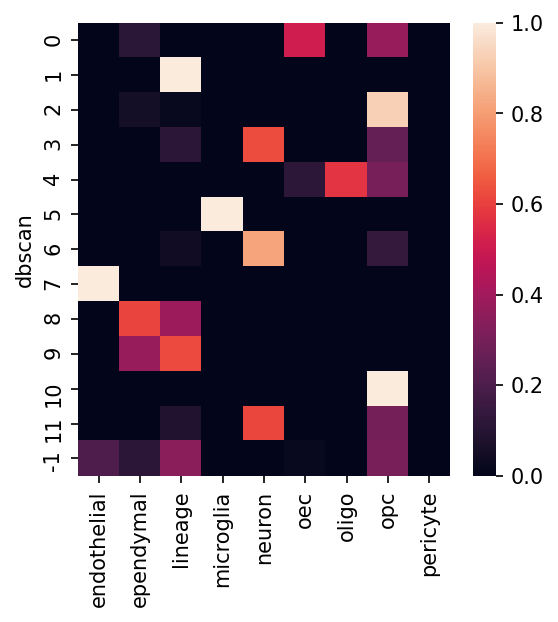

In [27]:
mat = d.obs[["dbscan"]].join(expr, how="left").groupby("dbscan").agg("median")
sns.heatmap(mat.divide(mat.sum(axis=1), axis=0))

<AxesSubplot:ylabel='dbscan'>

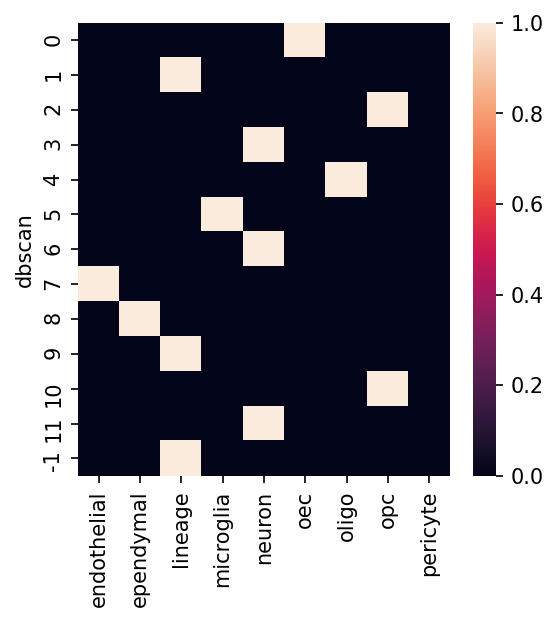

In [28]:
typemat = (np.max(mat, axis=1) == mat.transpose()).transpose()
sns.heatmap(typemat)

In [29]:
typemap = typemat.apply(lambda d: d.index[d][0], axis=1).to_dict()
typemap["-1"] = "singleton"
typemap

{'0': 'oec',
 '1': 'lineage',
 '2': 'opc',
 '3': 'neuron',
 '4': 'oligo',
 '5': 'microglia',
 '6': 'neuron',
 '7': 'endothelial',
 '8': 'ependymal',
 '9': 'lineage',
 '10': 'opc',
 '11': 'neuron',
 '-1': 'singleton'}

In [30]:
d.obs["celltype1"] = [typemap[i] for i in d.obs.dbscan]

... storing 'celltype1' as categorical


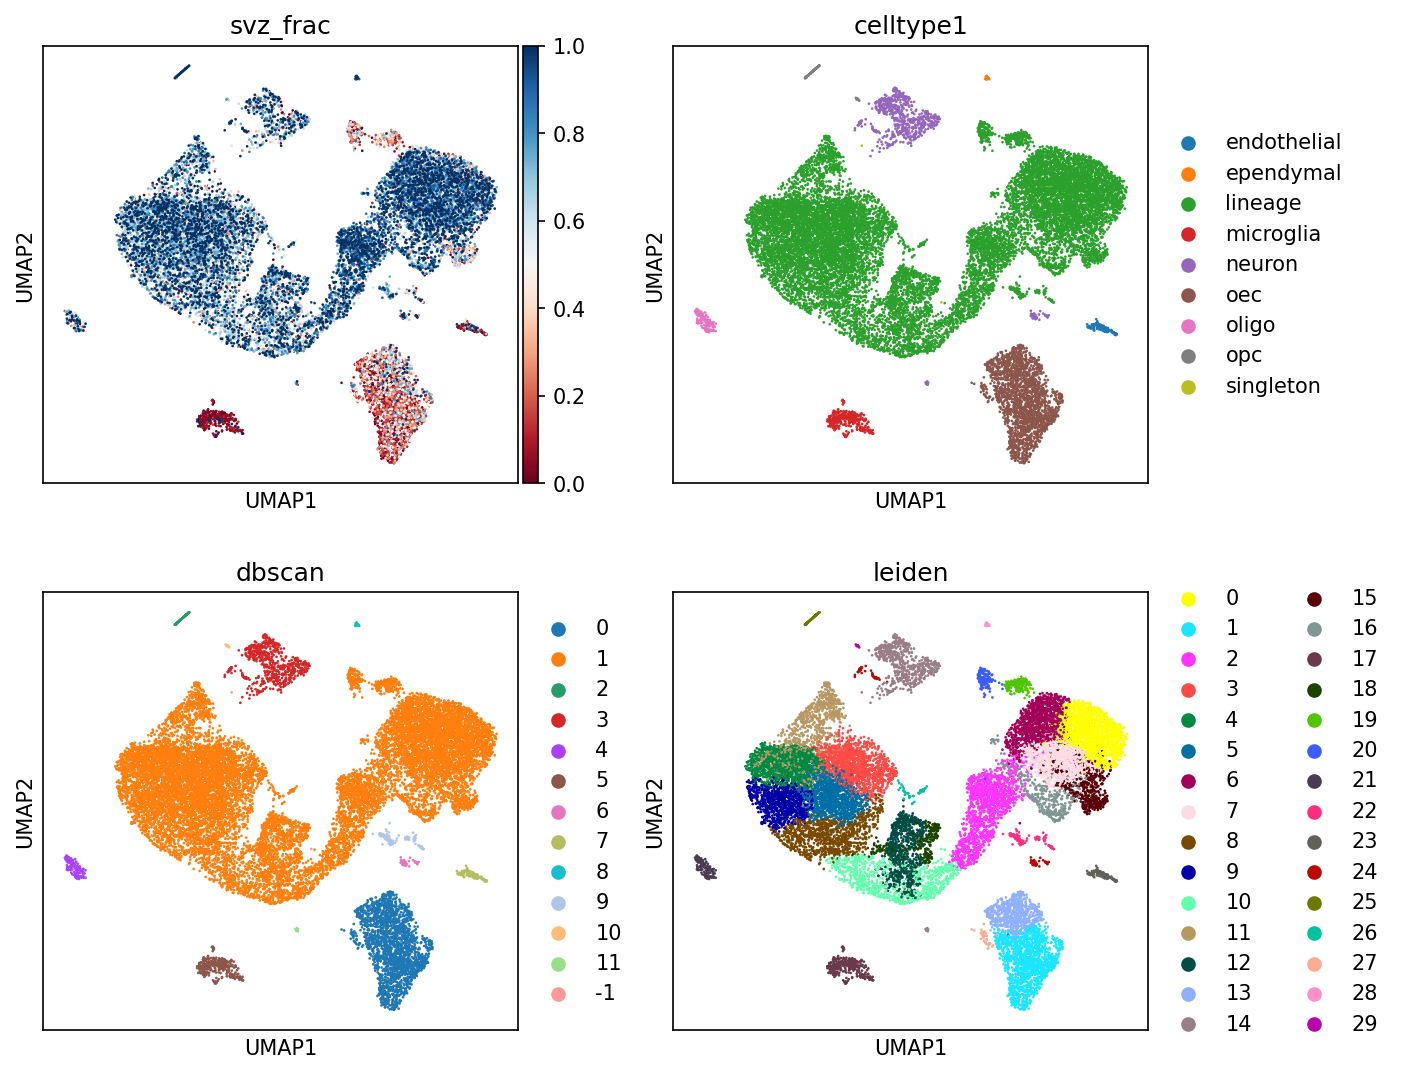

In [31]:
plt.rcParams['figure.figsize'] = [4, 4]
plt.rcParams['figure.dpi'] = 150
sc.pl.umap(d, color=["svz_frac", "celltype1", "dbscan", "leiden"], color_map=matplotlib.cm.RdBu, ncols=2)

# Celltype refinement

- `leiden:19` and `leiden:20` are actually not SVZ cells and thus should not be called `lineage`.
- `leiden:22` is likely to be further doublets

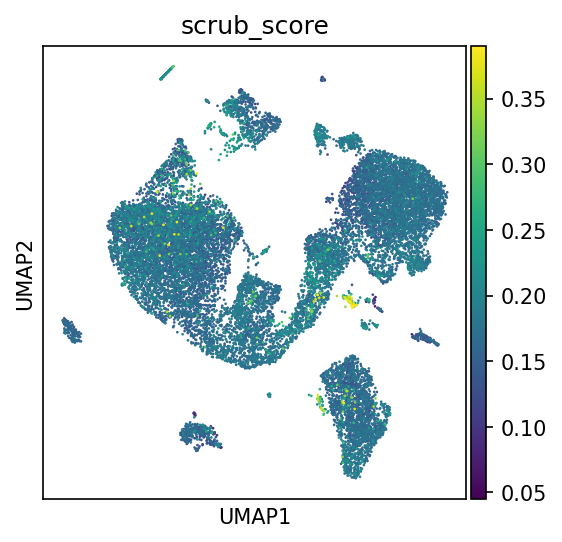

In [32]:
sc.pl.umap(d, color=["scrub_score"])

In [33]:
d.obs.celltype1 = d.obs.celltype1.astype(str)
d.obs.loc[d.obs.leiden=="19", "celltype1"] = "ob astrocyte"
d.obs.loc[d.obs.leiden=="20", "celltype1"] = "ob astrocyte"
d.obs.loc[(d.obs.leiden=="22"), "celltype1"] = "doublet"

... storing 'celltype1' as categorical


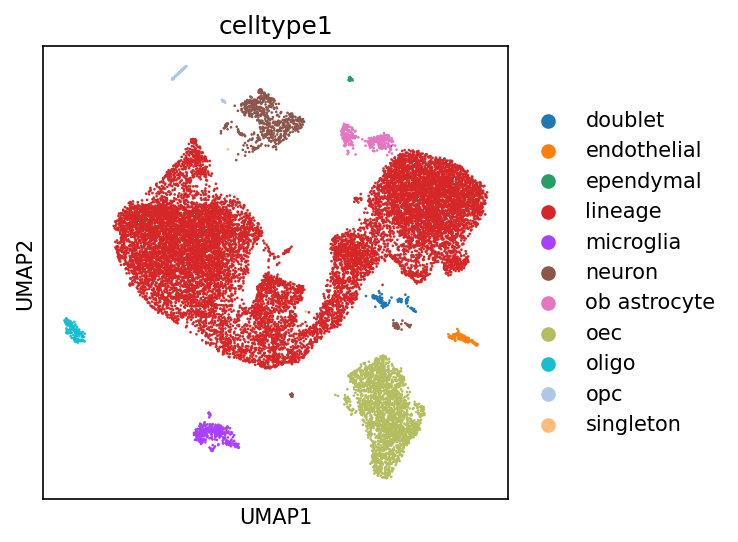

In [34]:
sc.pl.umap(d, color=["celltype1"])

# Pseudotime

In [35]:
dlin = d[d.obs.celltype1 == "lineage"].copy()
dlin.uns["iroot"] = np.argmax(dlin[:,"Aqp4"].X)
sc.tl.pca(dlin)
sc.pp.neighbors(dlin)
sc.tl.diffmap(dlin)
sc.tl.dpt(dlin)
d.obs = d.obs.join(dlin.obs[["dpt_pseudotime"]], how="left")
del dlin
d

AnnData object with n_obs × n_vars = 18302 × 20830
    obs: 'batch', 'yfp_count', 'kanr_count', 'SVZ1', 'SVZ2', 'ROB1', 'ROB2', 'unmapped', 'n_counts', 'counts', 'genes', 'counts_mito', 'frac_mito', 'scrub_score', 'scrub_label', 'exclude', 'genotype', 'age', 'leiden', 'dbscan', 'is_lineage', 'rob_sum', 'svz_sum', 'hto_sum', 'svz_frac', 'celltype1', 'dpt_pseudotime'
    var: 'gene_id', 'n_cells', 'mt', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'dbscan_colors', 'leiden_colors', 'celltype1_colors'
    obsm: 'hto', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'raw_counts', 'lognormal'
    obsp: 'distances', 'connectivities'

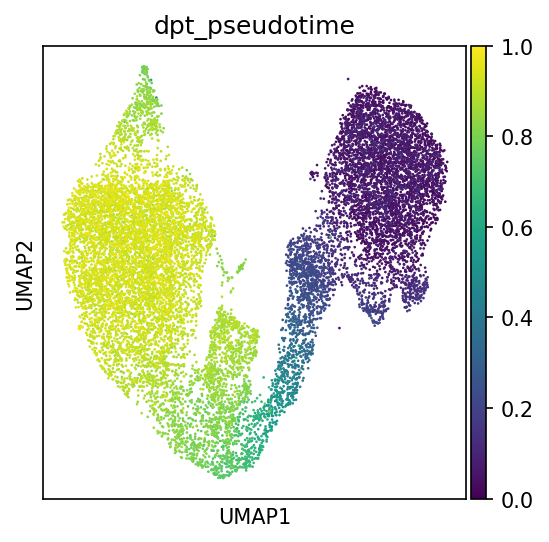

In [36]:
sc.pl.umap(d, color=["dpt_pseudotime"])

## Lineage celltypes

In [37]:
markers = ["Aqp4", "Egfr", "Dcx", "Mki67", "Gria1", "S100b"]

In [38]:
bin_count = 100

<AxesSubplot:xlabel='bin'>

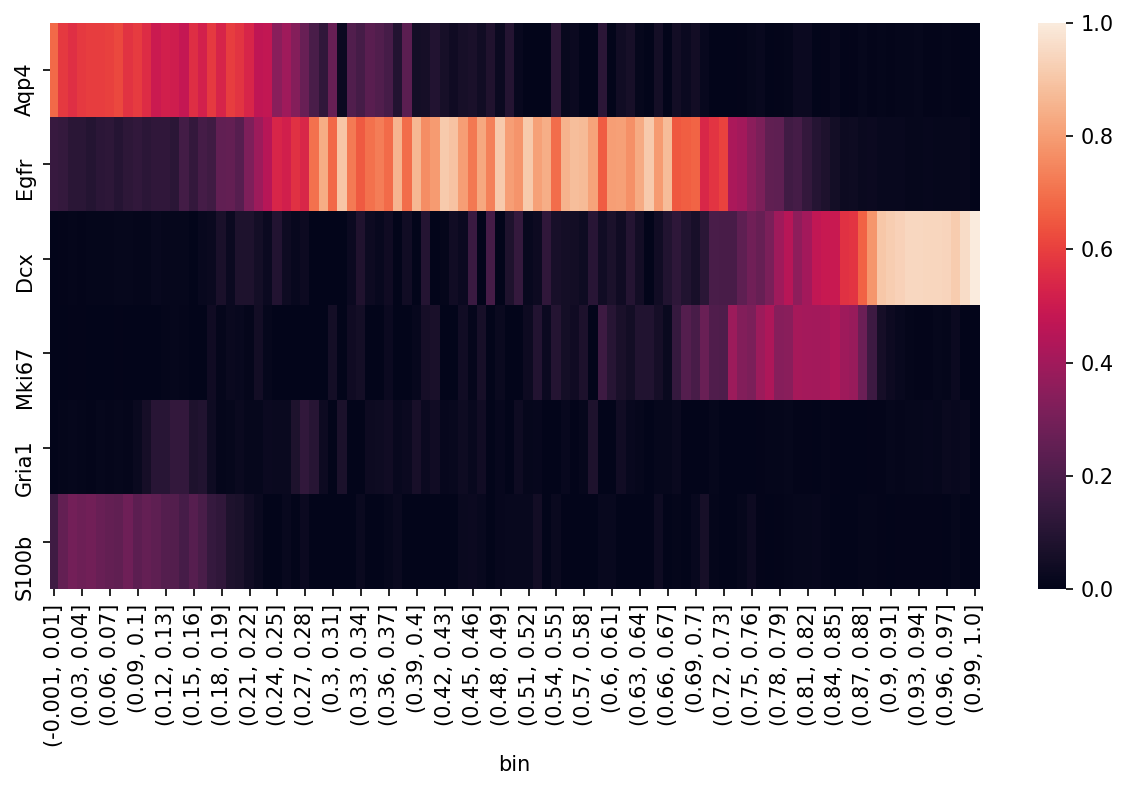

In [39]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 150
lineage_cells = d.obs.celltype1 == "lineage"
marker_data = pd.DataFrame(d[lineage_cells,markers].layers["lognormal"].todense(), columns=markers, index=d[lineage_cells,:].obs.index).join(d.obs, how="left")
marker_data["bin"] = pd.cut(marker_data.dpt_pseudotime, bins=bin_count)
marker_mat = marker_data.reset_index()[["bin"] + markers].groupby(["bin"]).sum()
sns.heatmap(marker_mat.divide(marker_mat.sum(axis=1), axis=0).transpose())

/home/jooa/.conda/envs/cycleflow/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/jooa/.conda/envs/cycleflow/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: plots/celltype_calling.pdf
/home/jooa/.conda/envs/cycleflow/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/jooa/.conda/envs/cycleflow/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: plots/celltype_calling.svg


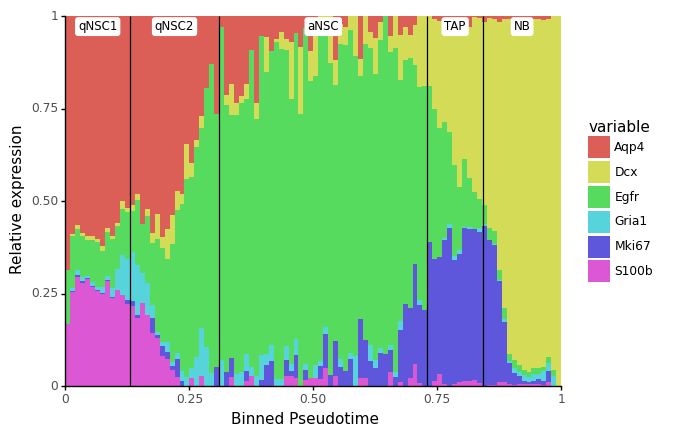

<ggplot: (8775825553773)>

In [40]:
cuts = [0.13, 0.31, 0.73, 0.842]
types = pd.DataFrame(
    {"lo": [0] + cuts,
     "hi": cuts + [1],
     "type": ["qNSC1", "qNSC2", "aNSC", "TAP", "NB"]
    }
)
types["dpt_pseudotime"] = types.lo + (types.hi-types.lo)/2
marker_mat = marker_data.reset_index()[["bin"] + markers].groupby("bin").sum()
marker_mat = marker_mat.divide(marker_mat.sum(axis=1), axis=0)
marker_mat = marker_mat.reset_index()
marker_mat["dpt_pseudotime"] = [b.mid for b in marker_mat.bin]
gg = (
    ggplot(marker_mat.melt(id_vars=["dpt_pseudotime", "bin"]), aes("dpt_pseudotime", "value")) +
    geom_bar(aes(fill="variable"), stat="identity", width=1/bin_count) +
    geom_vline(xintercept=cuts) +
    geom_label(aes(x="dpt_pseudotime", y=.99, label="type"), data=types, size=8.5, va="top", label_r=0, label_size=0) +
    coord_cartesian(expand=False) +
    labs(y="Relative expression", x="Binned Pseudotime", colour="Gene")
)
ggsave(gg, "plots/celltype_calling.pdf")
ggsave(gg, "plots/celltype_calling.svg")
gg

/home/jooa/.conda/envs/cycleflow/lib/python3.8/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_bin : Removed 3873 rows containing non-finite values.


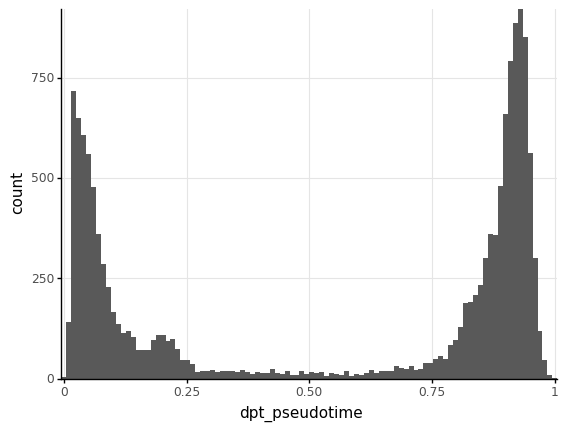

<ggplot: (8775825567495)>

In [41]:
ggplot(d.obs, aes("dpt_pseudotime")) + geom_histogram(bins=100) + coord_cartesian(expand=False)

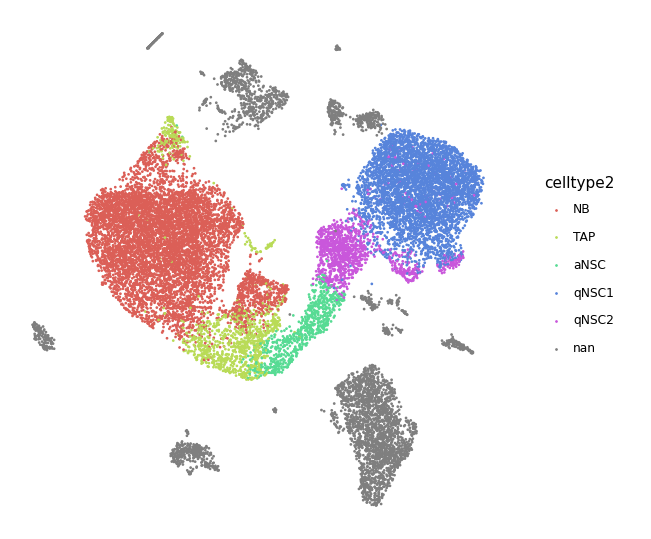

<ggplot: (8775825537247)>

In [42]:
d.obs["celltype2"] = [
    np.nan if pd.isna(x) else
    "qNSC1" if x < cuts[0] else 
    "qNSC2" if x < cuts[1] else 
    "aNSC"  if x < cuts[2] else
    "TAP"   if x < cuts[3] else
    "NB"    
    for x in d.obs.dpt_pseudotime
]
(
    ggplot(d.obs.assign(UMAP1 = d.obsm["X_umap"][:,0], UMAP2=d.obsm["X_umap"][:,1]), aes("UMAP1", "UMAP2")) +
    geom_point(aes(colour="celltype2"), size=0.1) +
    theme_void() +
    coord_equal()
)

In [43]:
d.obs["celltype"] = [c1 if pd.isna(c2) else f"{c1}:{c2}" for (c1, c2) in zip(d.obs.celltype1, d.obs.celltype2)]

# Summary

In [44]:
ddata = d.obs.assign(UMAP1 = d.obsm["X_umap"][:,0], UMAP2=d.obsm["X_umap"][:,1])

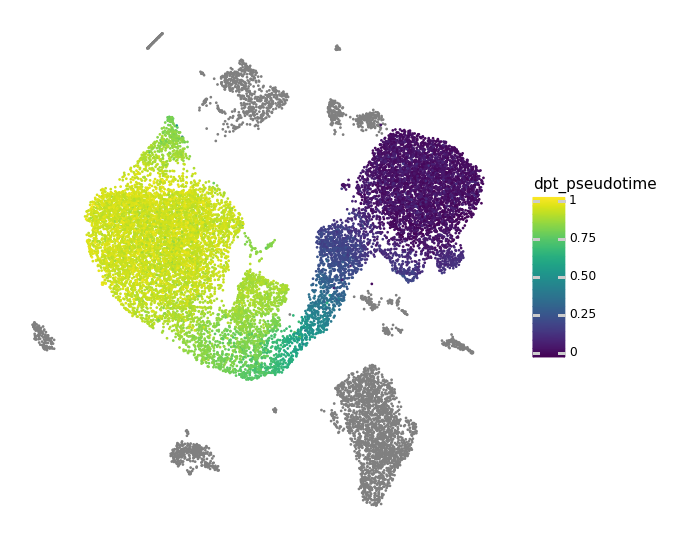

<ggplot: (8775828156784)>

In [45]:
(
    ggplot(ddata, aes("UMAP1", "UMAP2")) +
    geom_point(colour="gray", size=0.1, data=ddata.loc[ddata.celltype1 != "lineage"]) +
    geom_point(aes(colour="dpt_pseudotime"), size=0.1, data=ddata.loc[ddata.celltype1 == "lineage"]) +
    theme(axis_line=element_blank(), axis_ticks=element_blank(), panel_grid=element_blank(), axis_text=element_blank(), axis_title=element_blank()) +
    #theme_void() +
    #theme(legend_position="none") +
    coord_equal()
)

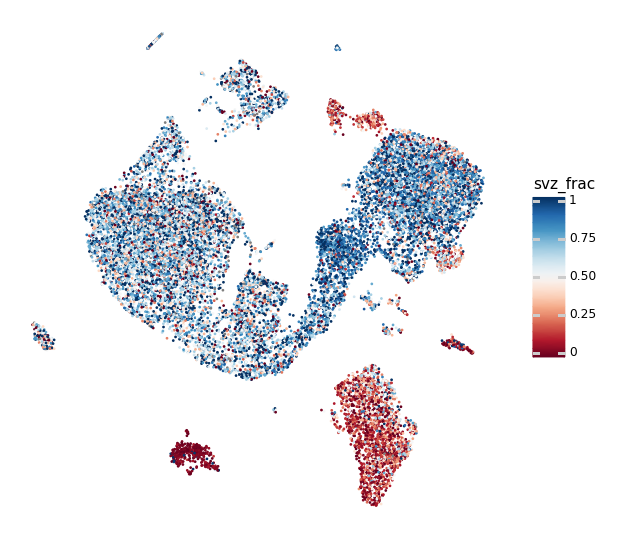

<ggplot: (8775815274912)>

In [46]:
(
    ggplot(ddata, aes("UMAP1", "UMAP2")) +
    geom_point(aes(colour="svz_frac"), size=0.1) +
    scale_colour_cmap(cmap_name="RdBu") +
    theme(axis_line=element_blank(), axis_ticks=element_blank(), panel_grid=element_blank(), axis_text=element_blank(), axis_title=element_blank()) +
    #theme_void() +
    #theme(legend_position="none") +
    coord_equal()
)

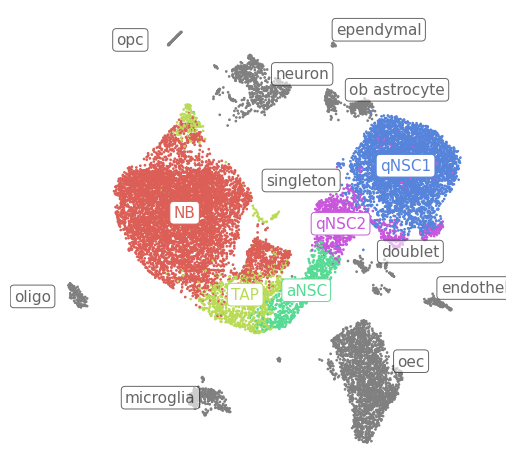

<ggplot: (8775828122567)>

In [47]:
dlabel1 = d.obs.assign(UMAP1 = d.obsm["X_umap"][:,0], UMAP2=d.obsm["X_umap"][:,1]).loc[:,["celltype1", "UMAP1", "UMAP2"]].groupby("celltype1").median()
dlabel1 = dlabel1.reset_index().loc[dlabel1.index != "lineage"]
dlabel2 = d.obs.assign(UMAP1 = d.obsm["X_umap"][:,0], UMAP2=d.obsm["X_umap"][:,1]).loc[d.obs.celltype1 == "lineage",["celltype2", "UMAP1", "UMAP2"]].groupby("celltype2").median().reset_index()
(
    ggplot(ddata, aes("UMAP1", "UMAP2")) +
    geom_point(colour="gray", size=0.1, data=ddata.loc[ddata.celltype1 != "lineage"]) +
    geom_point(aes(colour="celltype2"), size=0.1, data=ddata.loc[ddata.celltype1 == "lineage"]) +
    geom_label(aes(label="celltype1"), data=dlabel1[dlabel1.UMAP1 > 5], nudge_x=3, nudge_y=1, alpha=0.6) +
    geom_label(aes(label="celltype1"), data=dlabel1[dlabel1.UMAP1 < 5], nudge_x=-3, nudge_y=0, alpha=0.6) +
    geom_label(aes(label="celltype2", colour="celltype2"), data=dlabel2, nudge_x=0, alpha=1.0) +
    theme_void() +
    theme(legend_position="none") +
    coord_equal()
)

... storing 'celltype2' as categorical
... storing 'celltype' as categorical


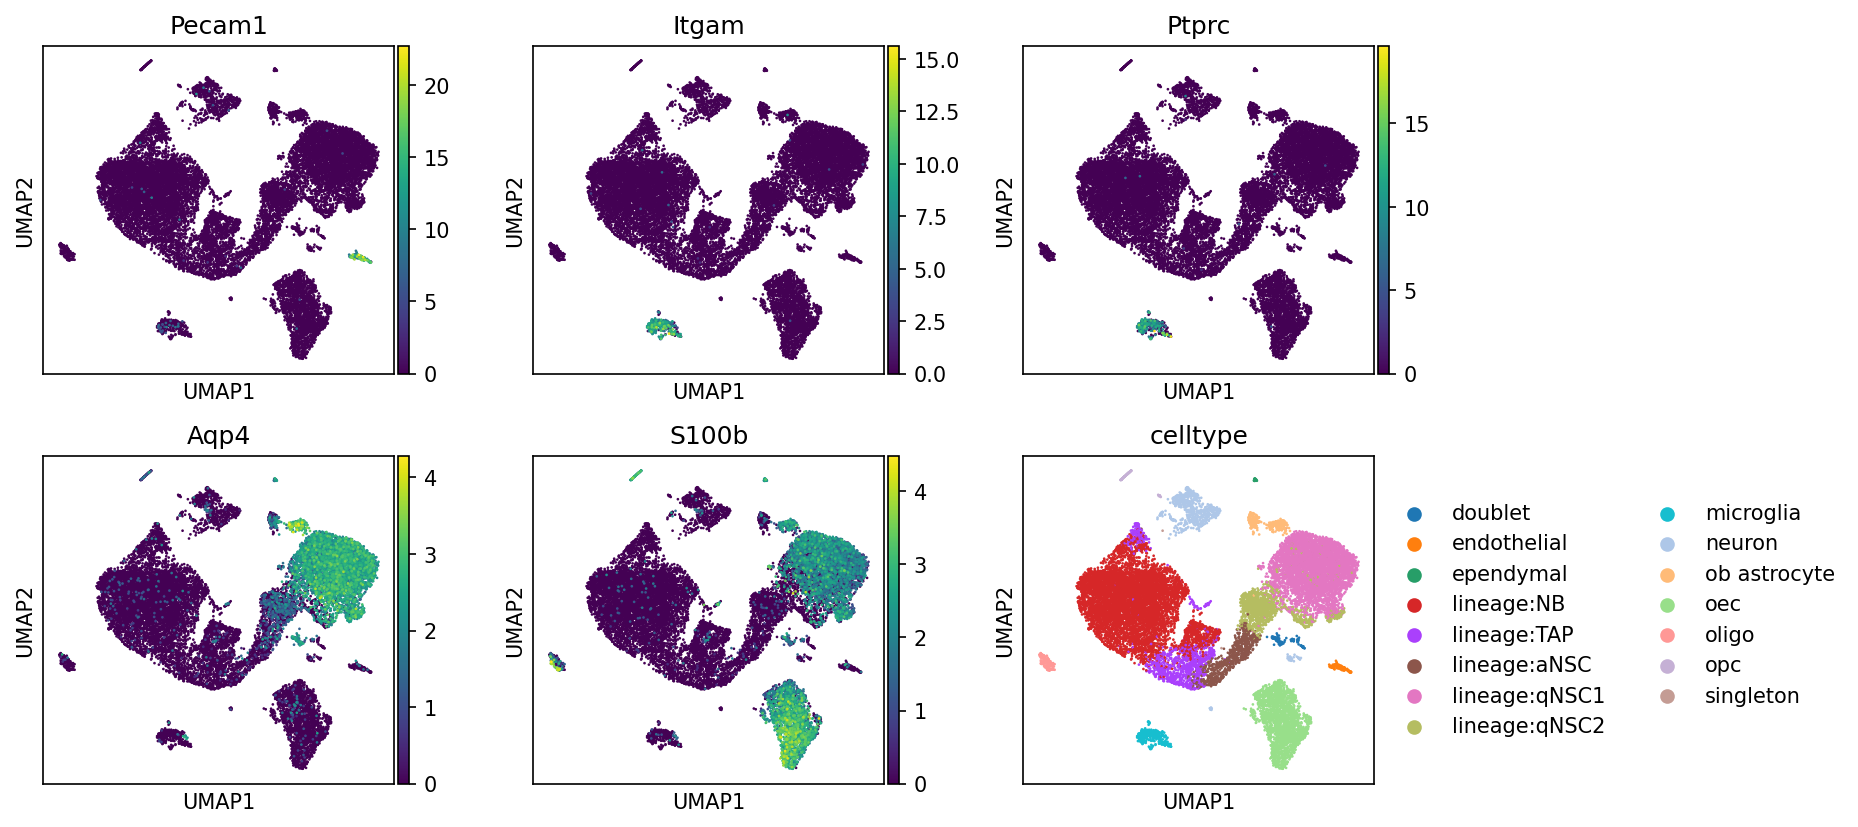

In [48]:
plt.rcParams['figure.figsize'] = [3, 3]
plt.rcParams['figure.dpi'] = 150
sc.pl.umap(d, color=["Pecam1", "Itgam", "Ptprc", "Aqp4", "S100b", "celltype"], ncols=3)

# Export

In [49]:
d.write_h5ad("computed/ifnagrko.h5ad")

In [50]:
d.obs.celltype.value_counts()

lineage:NB       6910
lineage:qNSC1    4491
oec              2075
lineage:qNSC2    1194
lineage:TAP      1118
lineage:aNSC      716
neuron            673
microglia         343
ob astrocyte      311
oligo             137
doublet           106
endothelial       103
opc                94
ependymal          29
singleton           2
Name: celltype, dtype: int64

In [51]:
columns = ["celltype", "celltype1", "celltype2", "dpt_pseudotime", "svz_frac", "hto_sum", "leiden", "dbscan", "frac_mito", "counts", "genes", "scrub_score", "age", "genotype"]

In [52]:
d.obs[columns].assign(UMAP1=d.obsm["X_umap"][:,0], UMAP2=d.obsm["X_umap"][:,1]).to_csv("computed/ifnagrko_obs.csv")

In [53]:
d.var.reset_index()[["gene_name", "gene_id"]].to_csv("computed/ifnagrko_var.csv")

In [54]:
with gzip.open("computed/ifnagrko_raw_counts.mtx.gz", "wb") as f:
    scipy.io.mmwrite(f, d.layers["raw_counts"])

In [55]:
with gzip.open("computed/ifnagrko_log_norm.mtx.gz", "wb") as f:
    scipy.io.mmwrite(f, d.layers["lognormal"])

In [56]:
pd.DataFrame(d.obsm["hto"], columns=hto_order, index=d.obs.index).to_csv("computed/hto_counts.csv.gz")

# Info

In [57]:
!pip list

Package                   Version
------------------------- -----------
amply                     0.1.4
anndata                   0.7.6
anyio                     2.2.0
apipkg                    1.5
appdirs                   1.4.4
argon2-cffi               20.1.0
astroid                   2.5.5
async-generator           1.10
attrs                     20.3.0
Babel                     2.9.0
backcall                  0.2.0
bleach                    3.3.0
bottle                    0.12.19
btrfsutil                 5.11.1
CacheControl              0.12.6
cffi                      1.14.5
chardet                   4.0.0
click                     7.1.2
colorama                  0.4.4
ConfigArgParse            1.4.1
contextlib2               0.6.0.post1
cryptography              3.4.7
cycleflow                 1.0
cycleflow-extra           0.0.1
cycler                    0.10.0
Cython                    0.29.23
datrie                    0.8.2
decorator                 4.4.2
defusedxml           